# Physics informed neural networks

In this notebook we'll go over the concepts of physics informed neural networks (PINNs), what their purpose is and how to use them.

## What and why

A physics informed neural network has the goal of solving a nonlinear partial differential equation through machine learning, without having to solve it analytically or with computationally intensive solvers. Such an equation looks as follows: 

$$\partial_t u(t, x) + \mathcal{N}[u](t,x) = 0$$


$$u(t,x) = $$

In this equation, $\partial_t u(t, x)$ represents the derivative of the function $u$ to time, and $\mathcal{N}$ is a non-linear operator acting on the function $u$. So in words, the how the functions $u$ behaves over time is dependent on a non-linear operator on the function $u$ itself over time.

Such an equation also has initial conditions, such as:

$$u(0, x) = u_0(x)$$

and boundary conditions, such as:
$$u(t, x) = u_b(t, x)$$

What we are trying to deciphher from these equations is the function $u$, complying to the equations given above.

One example of such an equation, is the Burgers equation, where the nonlinear operator on $u$ is as follows:

$$\mathcal{N}[u](x,t) = u \partial_x u - \frac{0.01}{\pi} \partial_{xx}u$$

The entire equation looks as follows:
$$
\begin{aligned}
    \partial_t u + u \partial_x u - \frac{0.01}{\pi} \partial_{xx} u & = 0, &&(t,x) \in (0,1] \times (-1,1)\\
   u(0,x) & = - \sin(\pi \, x), && x \in [-1,1]\\
   u(t,-1) = u(t,1) & = 0, && t \in (0,1]
\end{aligned}
$$

<figure>
<center>
<img src="https://jdongg.github.io/post/conservation-laws-1/gallery/burgers.gif" width="300">
<figcaption>Example of how the solution to a Burgers equation looks like. <a href=https://jdongg.github.io/post/conservation-laws-1/>source</a></figcaption>
</center>
</figure>

These types of equations can be very tough to solve analytically (sometimes impossible), and can be very compute intensive to solve with traditional solver techniques (such as the finite elements method). Luckily, our good old universal function approximator, the neural network, can try to derive this from data. In this process, the equations will help play a role in guiding the network towards the correct solution.

## Constructing a PINN

The physics will be integrated into the neural network through the use of the loss function. This loss function will take into account how well the output matches the data, but also how well it complies to the given physical equations.



The loss function usually consists of three parts, containing the loss with respect to the initial conditions, the boundary conditions, and the governing PDE:
$$\mathcal{L} = \mathcal{L}_0 + \mathcal{L}_b + \mathcal{L}_r$$

where the former two take the form of your usual machine learning loss function, such as mean squared error:

$$\frac{1}{N}\sum_{i=1}^{N}|u(t_i, x_i) - u_i)|^2$$

Here, $u(t_i, x_i)$ represents the output of the function predicted by the neural network, and $t_i$, $x_i$ and $u_i$ represent the $t$, $x$, and $u$ values in the data.

In order to comply with the initial and boundary conditions, this loss is computed for both conditions, which we define as $\mathcal{L}_0$ and $\mathcal{L}_b$ respectively:

$$\mathcal{L}_0 = \frac{1}{N_0}\sum_{i=1}^{N_0}|u(0, x_i^0) - u_i^0)|^2$$

Here, $N_0$ represents the number of training points where $t = 0$, $x_i^0$ represents the $x$ value of that data point at time 0, and $u_i^0$ represents the corresponding value of $u$ in the data.

$$\mathcal{L}_b = \frac{1}{N_b}\sum_{i=1}^{N_b}|(u_i^b(t_i^b, x_i^b)) - u_i^b|^2$$

Here, $N_b$ represents the number of training points at the boundaries ($x=-1$ or $x=1$ in the Burger's equation).

Next up, the loss will also include the residual term, indicating how much well the function is complying to the PDE. This loss is the residual of the PDE (how much it deviates from zero):
$$\mathcal{L}_r = \partial_t u(t, x) + \mathcal{N}[u](t,x)$$

Note that this loss function does not make use of data labels. The residual part of the loss function is an unsupervised part of the PINN.

Because of this loss function consisting of a supervised (for which you can generate the data yourself if you know the equations) and an unsupervised part, PINNs are often considered to be a semi-supervised machine learning method.

## Implementation example

Here, we give an example of an implementation of a PINN, using the Burger's equation as an example.

In [ ]:
# imports
import random
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense

In [ ]:
# Constants which will be used.
PI = tf.constant(np.pi)
VISCOSITY = 0.01 / PI

### Initial and boundary conditions
In this situation, we know the equations of the initial and boundary conditions. This allows us to generate the data from the initial and boundary conditions ourselves by randomly sampling input and calculating the output (this is an example of the fact that the more physical information you have, the less data you need to have in physics informed neural networks, as we are not using any external data here).

To generate the data correctly, we start by defining these initial and boundary conditions.

We have the initial condition:
$$u(0, x) = - \sin (\pi x)$$

In [ ]:
def get_u_0(x):
    """Returns the initial condition of u.
    
    Args:
        x: Space variable
    """
    return -tf.sin(PI*x)

and the boundary condition:

$$ u(t,-1) = u(t,1) = 0$$

In [ ]:
def get_u_b(t, x):
    """Returns the boundary condition of u.

    Args:
        t: Time variable
        x: Space variable
    """
    n = x.shape[0]
    return tf.zeros((n, 1))

### Generating data
First, we generate data. Here, we do uniform sampling for simplicity. Depending on the problem, literature can propose different sampling strategies.

In [ ]:
N_0 = 50
N_b = 50
N_r = 10000

# Generate data for initial condition. The time variable is 0 in the initial
# condition, the space variable is uniformly distributed between -1 and 1.
t_0 = tf.zeros((N_0, 1))
x_0 = tf.random.uniform((N_0, 1), -1, 1)

# Get value of u at time 0
u_0 = get_u_0(x_0)

# Generate data for the boundary condition. The time variable is uniformly
# distributed between 0 and 1, the space variable is randomly set to be either
# -1 or 1.
t_b = tf.random.uniform((N_b, 1), 0, 1)
x_b = [random.choice([-1, 1]) for _ in range(N_b)]
x_b = tf.reshape(tf.convert_to_tensor(x_b, dtype='float32'), (N_b, 1))

# Get value of u at boundary conditions (which is 0 in this case)
u_b = get_u_b(t_b, x_b)

# Create uniformly sampled points next to the data of the boundary conditions
t_r = tf.random.uniform((N_r, 1), 0, 1)
x_r = tf.random.uniform((N_r, 1), -1, 1)

### Model definition

Here we try to implement a neural network trying to predict the solution to the Burger's equation. First up, we will define a model. The model will represent the method $u(x,t)$, having an input shape of $2$ (containing $x$ and $t$), and an output shape of $1$, containing the output of $u$.

In [ ]:
model = tf.keras.Sequential()
# Input size 2, one for time, other for the space dimension.
model.add(tf.keras.Input(2))
# Adding some layers. tanh activation function seems to work better
# than relu for PINNs
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
# Add output layer
model.add(Dense(1))

### Loss function

To calculate the loss, we define the residual term: $$\mathcal{L}_r = \partial_t u + u \partial_x u- \frac{0.01}{\pi} \partial_{xx}u $$

In [ ]:
def get_f(model, t, x):
    """Returns the residual term.
    
    Args:
        model: The model that is used to approximate u
        t: Time variable
        x: Space variable
    
    Returns:
        The caulcated residual loss.
    """
    # Use GradientTape to compute derivatives
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        tape.watch(x)

        u = model(tf.concat([t, x], axis=1))

        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)

    return u_t + u*u_x - VISCOSITY * u_xx

In [ ]:
def compute_loss(model, t_r, x_r, t_0, x_0, u_0, t_b, x_b, u_b):
    """Compute the loss function. This is a combination of the residual
      from the PDE, and the loss from the initial and boundary conidition data.
    
    Args:
        model: The model that is used to approximate u
        t_r: Time variable from data used for the residual
        x_r: Space variable from data used for the residual
        t_0: Time variable from data used at time 0 in data
        x_0: Space variable from data used at time 0 in data
        u_0: Value of u from data at time 0
        t_b: Time variable from data used at boundaries
        x_b: Space variable from data used at boundaries
        u_b: Value of u from data at boundaries
    
    Returns:
        The calculated loss.
    """
    loss = 0

    # Compute the residual and add to the loss term
    f = get_f(model, t_r, x_r)
    loss += tf.reduce_mean(tf.square(f))

    # Add loss for initial conditions
    u_0_pred = model(tf.concat([t_0, x_0], axis=1))
    loss += tf.reduce_mean(tf.square(u_0 - u_0_pred))

    # Add loss for boundary conditions
    u_b_pred = model(tf.concat([t_b, x_b], axis=1))
    loss += tf.reduce_mean(tf.square(u_b - u_b_pred))

    return loss

In [ ]:
def get_grad(model, t_r, x_r, t_0, x_0, u_0, t_b, x_b, u_b):
    """Caculates the loss and gradient of the model.
    
    Args:
        model: The model that is used to approximate u
        t_r: Time variable from data used for the residual
        x_r: Space variable from data used for the residual
        t_0: Time variable from data used at time 0 in data
        x_0: Space variable from data used at time 0 in data
        u_0: Value of u from data at time 0
        t_b: Time variable from data used at boundaries
        x_b: Space variable from data used at boundaries
        u_b: Value of u from data at boundaries
    
    Returns:
        The calculated and gradient.
    """
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivates with respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, t_r, x_r, t_0, x_0, u_0, t_b, x_b, u_b)

        g = tape.gradient(loss, model.trainable_variables)
    
    return loss, g

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate = 0.001)

### Model training

In [ ]:
# Define the training step
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, t_r, x_r, t_0, x_0, u_0, t_b, x_b, u_b)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

num_epochs = 2000
for i in range(num_epochs):
    loss = train_step()
    if i % 100 == 0:
      print(i)
      print(loss)

### Visualization
By running the code below, you can plot the result of the solution for different points in time and space.

If everything went well, the resulting figure should look similar to the shape of the gif shown earlier for the different points in space and time.

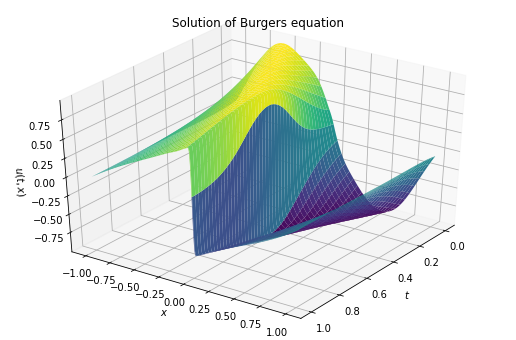

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

# Set up meshgrid
N = 600
tspace = np.linspace(0, 1, N + 1)
xspace = np.linspace(-1, 1, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(Xgrid)

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(t,x)$')
ax.set_title('Solution of Burgers equation');

## DeepXDE
To get a feeling of how PINNs work, we implemented them above from scratch using TensorFlow. However, there are tools such as [DeepXDE](https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/Burgers.py) that help you in the implementation. This library abstracts away stuff like the data generation step we did above.

First install the DeepXDE package

In [ ]:
!pip install DeepXDE

Perform the necessary imports

In [ ]:
import deepxde as dde
import numpy as np

### Implementation

In [ ]:
# Define the equation of the PDE
def pde(x, u):
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # First order derivative to variable x
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # First order derivative to variable t
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # Second order derivative to variable x
    return u_t + u * u_x - 0.01 / np.pi * u_xx

In [ ]:
# Define the space and time domain of the PDE
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Create the initial and boundary condition objects
bc = dde.icbc.DirichletBC(
    geom=geomtime,
    func=lambda x: 0,
    on_boundary=lambda _, on_boundary: on_boundary
)
ic = dde.icbc.IC(
    geom=geomtime,
    func=lambda x: -np.sin(np.pi * x[:, 0:1]),
    on_initial=lambda _, on_initial: on_initial
)

In [ ]:
# The domain, pde, and boundary / initial conditions together form the "data"
# which will be used to train the model.
data = dde.data.TimePDE(
    geometryxtime=geomtime,
    pde=pde,
    ic_bcs=[bc, ic],
    num_domain=10000, # Number of training points within the boundary conditions
    num_boundary=50, # Number of training points on the boundary
    num_initial=50, # Number of training points on initial condition
)

# Use fully connected neural network (FNN) architecture
net = dde.nn.FNN(
    layer_sizes=[2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
    activation='tanh',
    kernel_initializer='Glorot normal'
)

In [ ]:
# Compile and train the model
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=2000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### Visualization
By running the cell below, you can plot the result. If all went well, you should see a similar figure as was created for the first method.

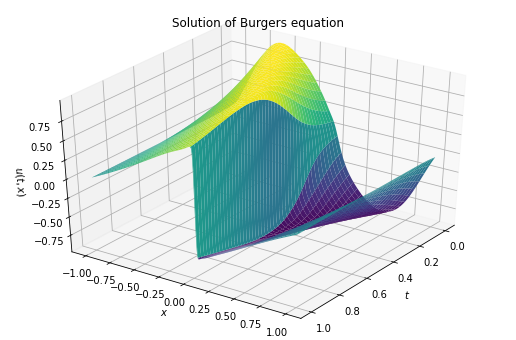

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

# Set up meshgrid
N = 600
tspace = np.linspace(0, 1, N + 1)
xspace = np.linspace(-1, 1, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

# Determine predictions of u(t, x)
upred = model.predict(Xgrid)

# Reshape upred
U = upred.reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(t,x)$')
ax.set_title('Solution of Burgers equation');

## Conclusion

Physics informed neural networks (PINNs), originating from a [paper](https://arxiv.org/pdf/1711.10561.pdf) in 2018, is a technique to solve partial differential equations through the use of machine learning. Depending on the use case, this can be significantly more efficient than use solvers such as the finite element method, as conventional solvers need to be run for each point in space and time (while a neural network is mainly compute intensive during training, but lightweight during inference).

This notebook shows how you can implement a PINN yourself in TensorFlow, and there are tools such as [DeepXDE](https://deepxde.readthedocs.io/en/latest/) that can simplify this.

PINNs are one of the many techniques to incorporate physical knowledge into machine learning. The umbrella term for this is physics informed machine learning, and can come into play when the problem you are trying to solve is heavily governed by the laws of physics (which in reality, are often in the form of differential equations).